In [1]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
from scipy import stats as st

# modeling routines from Scikit Learn packages
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from math import sqrt  # for root mean-squared error calculation

In [2]:
# read data for the Boston Housing Study
# creating data frame restdata
boston_input = pd.read_csv('boston.csv')

# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
print(boston_input.head())
print(boston_input.tail())

print('\nGeneral description of the boston_input DataFrame:')
print(boston_input.info())

# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\nGeneral description of the boston DataFrame:')
print(boston.info())

print('\nDescriptive statistics of the boston DataFrame:')
print(boston.describe())


boston DataFrame (first and last five rows):
  neighborhood     crim    zn  indus  chas    nox  rooms   age     dis  rad  \
0       Nahant  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1   Swampscott  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2   Swanpscott  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3   Marblehead  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4   Marblehead  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio  lstat    mv  
0  296     15.3   4.98  24.0  
1  242     17.8   9.14  21.6  
2  242     17.8   4.03  34.7  
3  222     18.7   2.94  33.4  
4  222     18.7   5.33  36.2  
    neighborhood     crim   zn  indus  chas    nox  rooms   age     dis  rad  \
501     Winthrop  0.06263  0.0  11.93     0  0.573  6.593  69.1  2.4786    1   
502     Winthrop  0.04527  0.0  11.93     0  0.573  6.120  76.7  2.2875    1   
503     Winthrop  0.06076  0.0  11.93     0  0.573  6

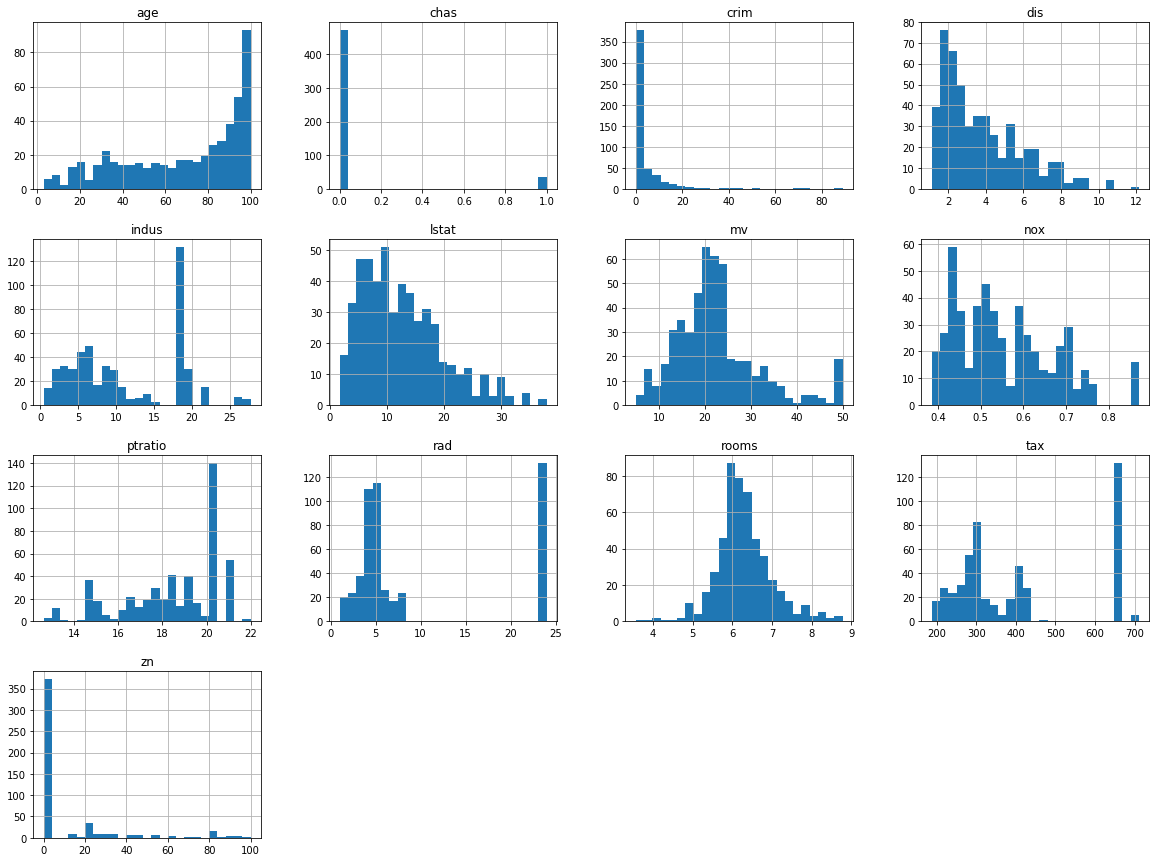

In [3]:
boston.hist(bins=25, figsize=(20,15))
plt.show()

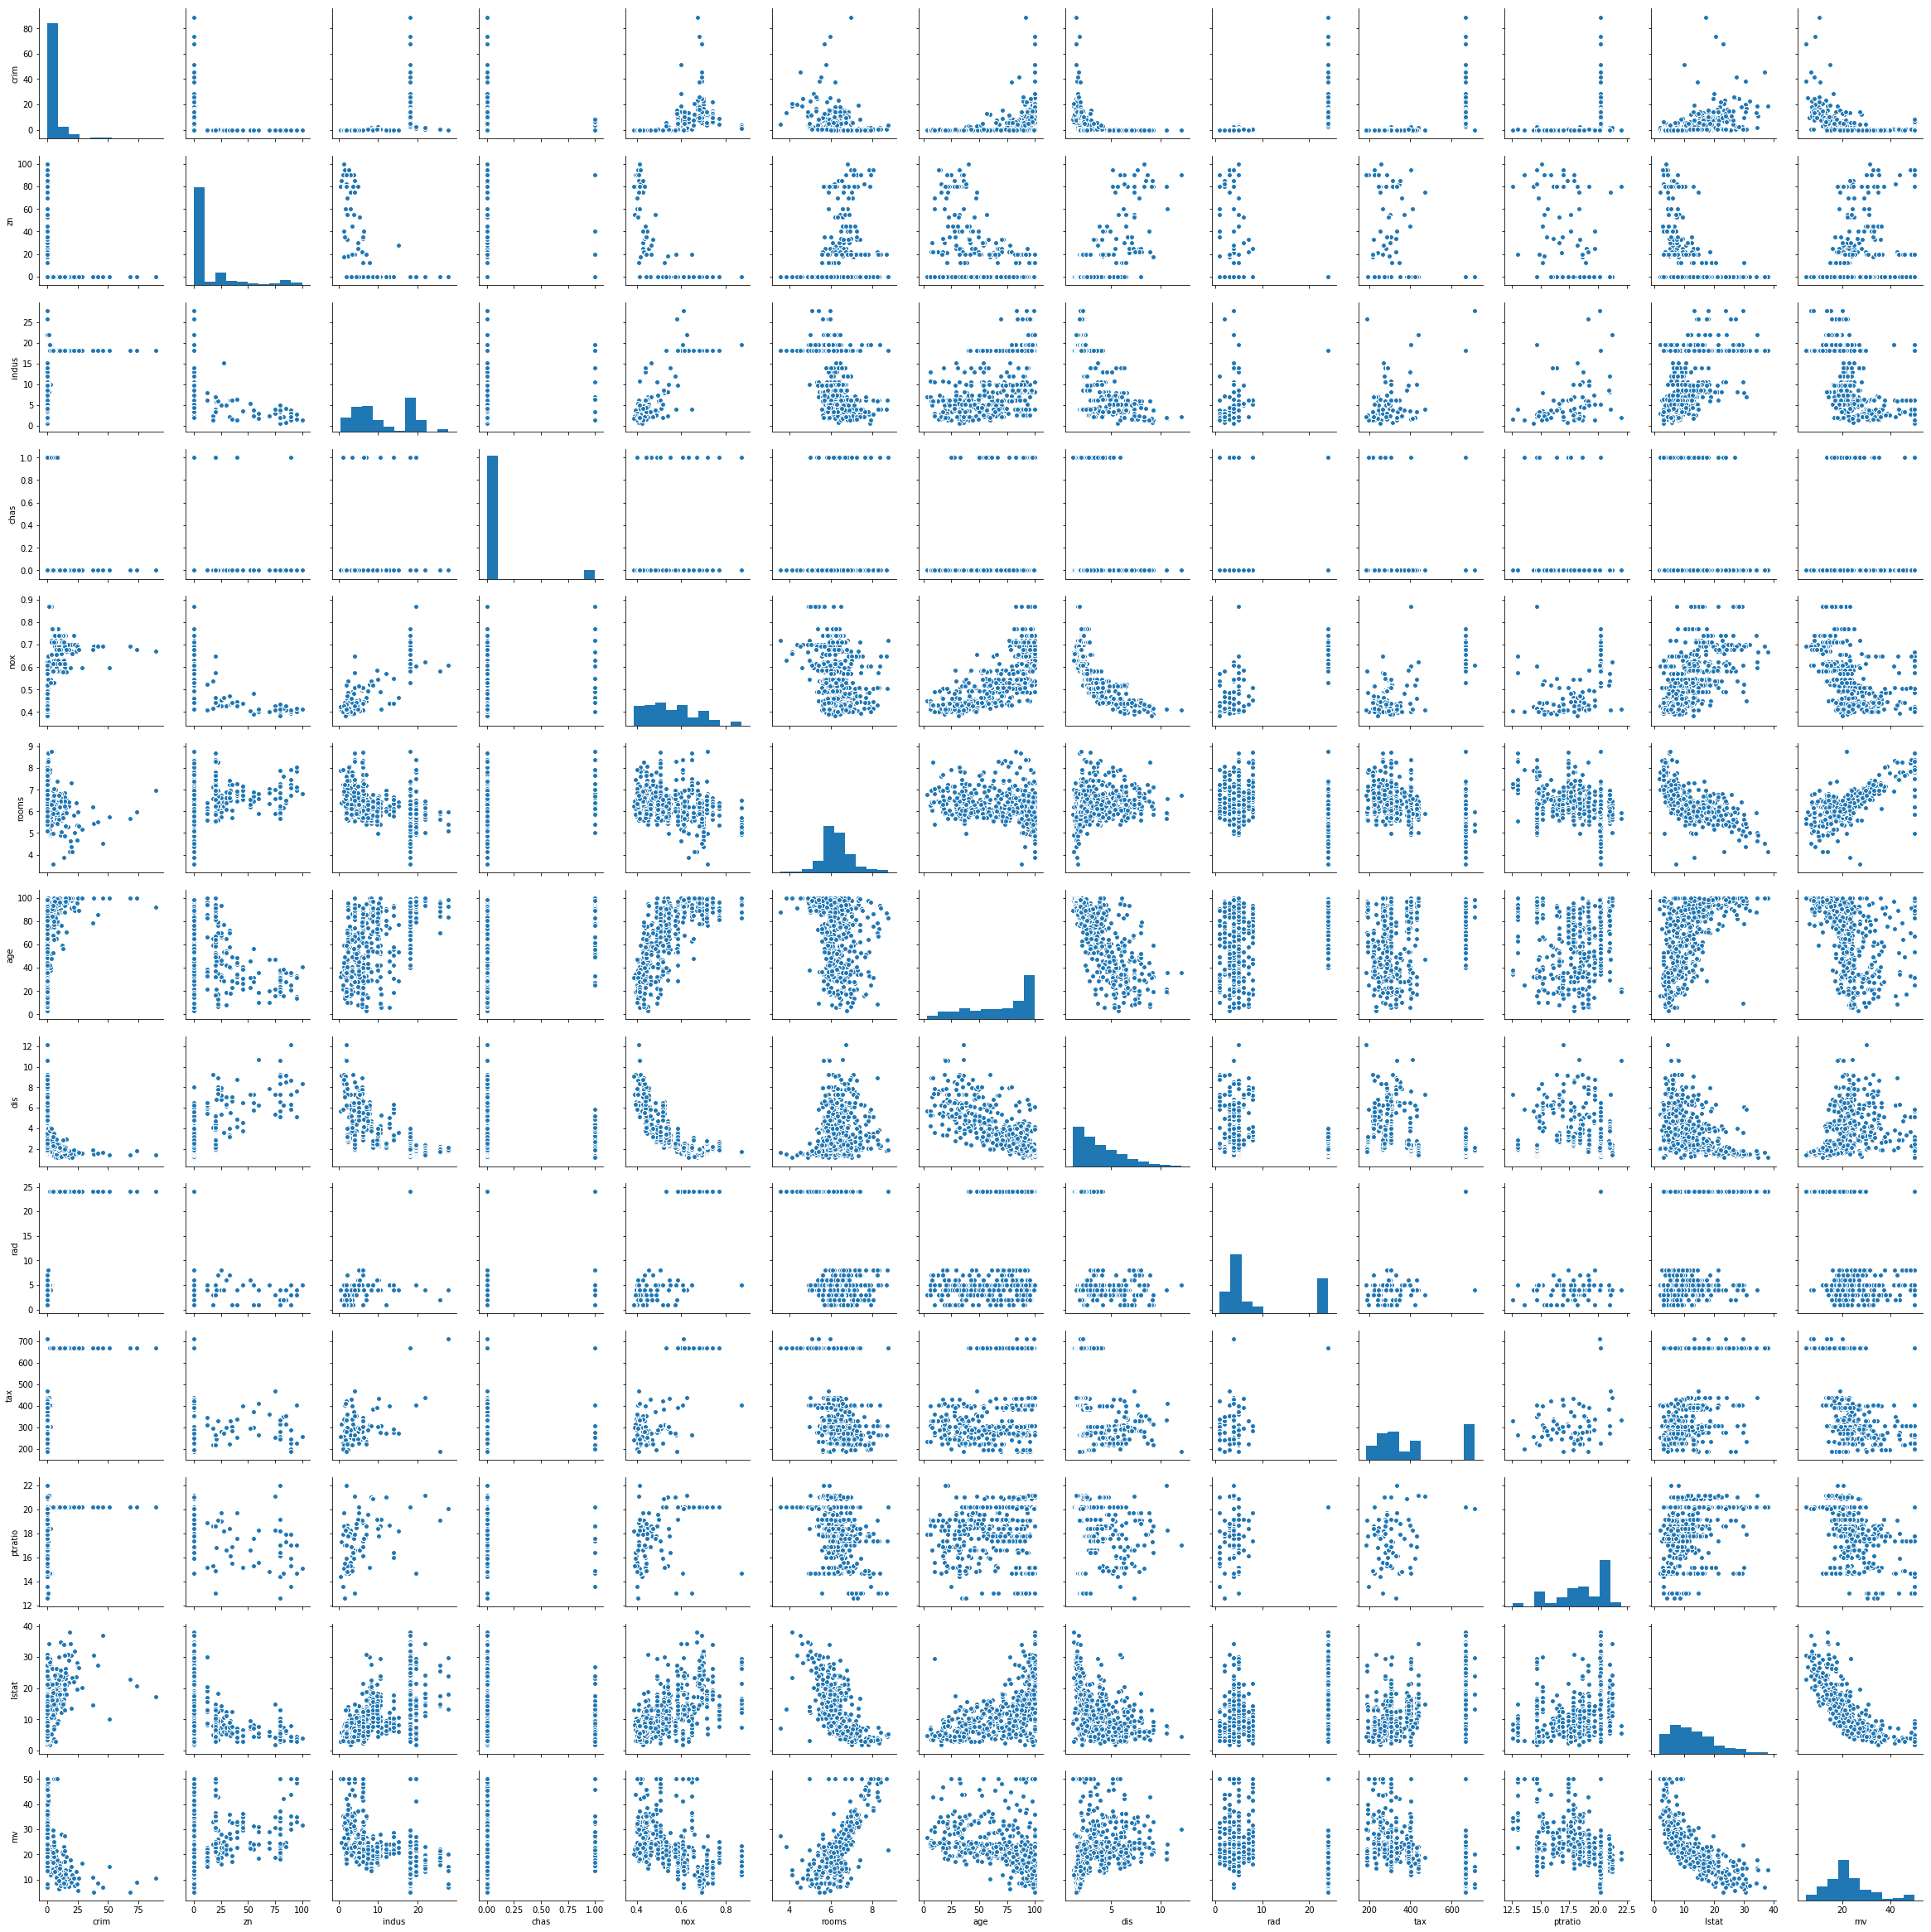

In [4]:
sns.pairplot(boston_input)

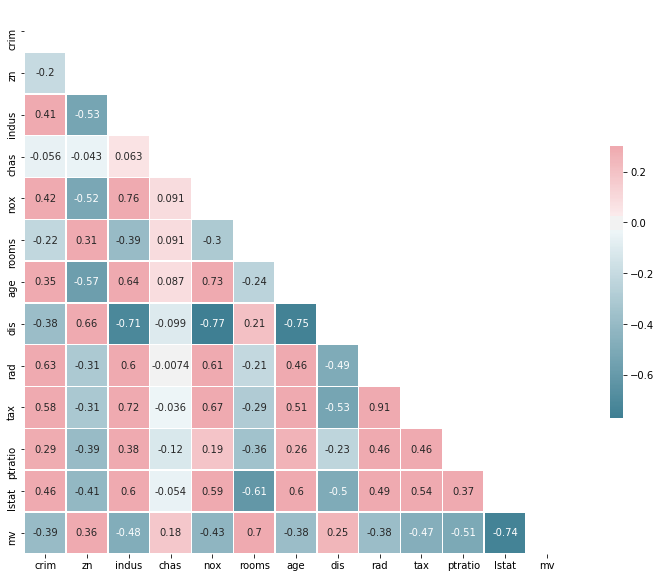

In [5]:
plt.figure(figsize=(15,10))
corr = boston.corr(method="pearson")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, vmax=.3, center=0,
           square=True, linewidth=.5, cbar=.5, cbar_kws={"shrink": .5})
plt.show()

In [6]:
# set up preliminary data for data for fitting the models 
# the first column is the median housing value response
# the remaining columns are the explanatory variables
prelim_model_data = np.array([boston.mv,\
    boston.crim,\
    boston.zn,\
    boston.indus,\
    boston.chas,\
    boston.nox,\
    boston.rooms,\
    boston.age,\
    boston.dis,\
    boston.rad,\
    boston.tax,\
    boston.ptratio,\
    boston.lstat]).T

# dimensions of the polynomial model X input and y response
# preliminary data before standardization
print('\nData dimensions:', prelim_model_data.shape)


Data dimensions: (506, 13)


In [7]:
# standard scores for the columns... along axis 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(prelim_model_data))
# show standardization constants being employed
print(scaler.mean_)
print(scaler.scale_)

StandardScaler(copy=True, with_mean=True, with_std=True)
[2.25288538e+01 3.61352356e+00 1.13636364e+01 1.11367787e+01
 6.91699605e-02 5.54695059e-01 6.28463439e+00 6.85749012e+01
 3.79504269e+00 9.54940711e+00 4.08237154e+02 1.84555336e+01
 1.26530632e+01]
[9.17309810e+00 8.59304135e+00 2.32993957e+01 6.85357058e+00
 2.53742935e-01 1.15763115e-01 7.01922514e-01 2.81210326e+01
 2.10362836e+00 8.69865112e+00 1.68370495e+02 2.16280519e+00
 7.13400164e+00]


In [8]:
# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', model_data.shape)


Dimensions for model_data: (506, 13)


In [9]:
cols = boston.columns.tolist()
cols = cols[-1:] + cols[:-1]
boston = boston[cols]
boston_data = pd.DataFrame(model_data, columns = boston.columns)

In [10]:
boston_data.head()

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.160376,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,-1.075562
1,-0.101258,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,-0.492439
2,1.326830,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,-1.208727
3,1.185112,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,-1.361517
4,1.490352,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,-1.026501


In [11]:
X = boston_data.loc[:, boston_data.columns != 'mv'].values
y = boston_data.mv

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
lr = LinearRegression(fit_intercept = True, normalize = False)
lr.fit(X_train, y_train)

lr_predict = lr.predict(X_test)

print("Linear Regression Training Score: {:.2f}".format(lr.score(X_train,y_train)))
print("Linear Regression Testing Score: {:.2f}".format(lr.score(X_test, y_test)))
print("RSME: {:.2f}".format(sqrt(mean_squared_error(y_test, lr_predict))))

Linear Regression Training Score: 0.76
Linear Regression Testing Score: 0.67
RSME: 0.57


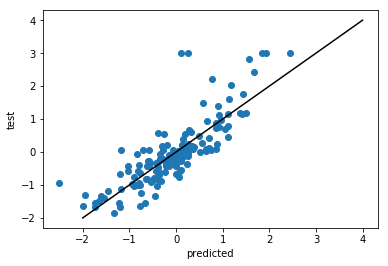

In [14]:
plt.scatter(lr_predict, y_test)
plt.plot([-2,4],[-2,4], color = "black")
plt.xlabel('predicted')
plt.ylabel('test')
plt.show()

In [15]:
RANDOM_SEED = 1

rr = Ridge(alpha = 75, solver = 'cholesky', fit_intercept = True, normalize = False, random_state = RANDOM_SEED)
rr.fit(X_train, y_train)

rr_predict = rr.predict(X_test)

print("Ridge Regression Training Score: {:.2f}".format(rr.score(X_train,y_train)))
print("Ridge Regression Testing Score: {:.2f}".format(rr.score(X_test, y_test)))
print("RSME: {:.2f}".format(sqrt(mean_squared_error(y_test, rr_predict))))

Ridge Regression Training Score: 0.74
Ridge Regression Testing Score: 0.64
RSME: 0.60


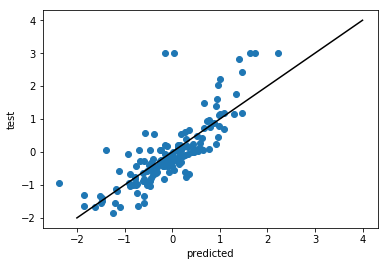

In [16]:
plt.scatter(rr_predict, y_test)
plt.plot([-2,4],[-2,4], color = "black")
plt.xlabel('predicted')
plt.ylabel('test')
plt.show()

In [17]:
RANDOM_SEED = 1

lar = Lasso(alpha = 0.001, max_iter = 10000, tol = 0.01, fit_intercept = True, normalize = False, 
            random_state = RANDOM_SEED)
lar.fit(X_train, y_train)

lar_predict = lar.predict(X_test)

print("Lasso Regression Training Score: {:.2f}".format(lar.score(X_train,y_train)))
print("Lasso Regression Testing Score: {:.2f}".format(lar.score(X_test, y_test)))
print("RSME: {:.2f}".format(sqrt(mean_squared_error(y_test, lar_predict))))

Lasso Regression Training Score: 0.76
Lasso Regression Testing Score: 0.67
RSME: 0.57


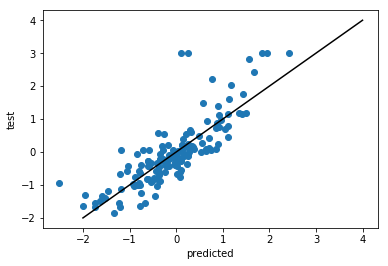

In [18]:
plt.scatter(lar_predict, y_test)
plt.plot([-2,4],[-2,4], color = "black")
plt.xlabel('predicted')
plt.ylabel('test')
plt.show()

In [19]:
RANDOM_SEED = 1

names = ['Linear_Regression', 'Ridge Regression', 'Lasso_Regression']

regressors = [LinearRegression(fit_intercept = True, normalize = False),
             Ridge(alpha = 100, solver = 'cholesky', fit_intercept = True, normalize = False, 
                   random_state = RANDOM_SEED),
             Lasso(alpha = 0.01, max_iter = 10000, tol = 0.01, fit_intercept = True, normalize = False, 
                   random_state = RANDOM_SEED)]

In [20]:
N_FOLDS = 10

cv_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle = False, random_state = RANDOM_SEED)

index_for_fold = 0
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '-----------------------------------------------------------------------')
    x_train = model_data[train_index, 1:model_data.shape[1]]
    x_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]
    
    index_for_method = 0
    for name, reg_model in zip(names, regressors):
        reg_model.fit(x_train, y_train)
        y_test_predict = reg_model.predict(x_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n-----------------------------------------------------------------------')
print('Average results form ', N_FOLDS, '-fold cross-validation',
     'in standard units (mean 0, standard deviation 1)\n',
     '\nMethod               Root mean-squared error', sep = '')
print(cv_results_df.mean())


Fold index: 0 -----------------------------------------------------------------------

Fold index: 1 -----------------------------------------------------------------------

Fold index: 2 -----------------------------------------------------------------------

Fold index: 3 -----------------------------------------------------------------------

Fold index: 4 -----------------------------------------------------------------------

Fold index: 5 -----------------------------------------------------------------------

Fold index: 6 -----------------------------------------------------------------------

Fold index: 7 -----------------------------------------------------------------------

Fold index: 8 -----------------------------------------------------------------------

Fold index: 9 -----------------------------------------------------------------------

-----------------------------------------------------------------------
Average results form 10-fold cross-validationin standard 